In [1]:
import platform

In [2]:
import numpy as np
import mrcfile
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf
from tensorflow import spectral
from ClassFiles.relion_fixed_it import load_star
from ClassFiles.AdversarialRegularizer import AdversarialRegulariser
from ClassFiles.ut import l2
from ClassFiles.Utilities import registration
from ClassFiles.ut import locate_gt, rfft, irfft, unify_form, Rescaler

In [3]:
# saves_path = '/local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/AllData/AllAugmentation'
PLATFORM_NODE = platform.node()
if  PLATFORM_NODE == 'gelfand':
    saves_path = '/mnt/data/zickert/'
elif PLATFORM_NODE == 'motel':
    saves_path = '/local/scratch/public/sl767/'
saves_path += 'SPA/Saves/Adversarial_Regulariser/Cutoff_20/Translation_Augmentation'
regularizer = AdversarialRegulariser(saves_path)

INFO:tensorflow:Restoring parameters from /mnt/data/zickert/SPA/Saves/Adversarial_Regulariser/Cutoff_20/Translation_Augmentation/Data/model-20000
Save restored


In [5]:
NUM_VOX = 150
TARGET_NUM_VOX = 96
IMAGING_SCALE = 300

def vis(data, fourier=True):
    if fourier:
        data = irfft(data, scaling=NUM_VOX**2)
    slice_n = int(data.shape[0]//2)
    plt.imshow(IMAGING_SCALE*data.squeeze()[..., slice_n])
    
def downsample(image, in_res = NUM_VOX, out_res = TARGET_NUM_VOX):
    reco_ds = np.copy(image)
    reco_ds = np.fft.fftshift(reco_ds, axes=(0,1))
    reco_ds = reco_ds[in_res//2-out_res//2 : in_res//2+out_res//2, 
                      in_res//2-out_res//2 : in_res//2+out_res//2, 
                      0:(out_res//2)+1]
    return np.fft.ifftshift(reco_ds, axes=(0,1))

def upsample(image, in_res = TARGET_NUM_VOX, out_res = NUM_VOX):
    shape = (out_res, out_res, out_res//2 +1)
    res = np.zeros(shape)
    res[out_res//2-in_res//2 : out_res//2+in_res//2, 
        out_res//2-in_res//2 : out_res//2+in_res//2, 
        0:(in_res//2)+1] = np.fft.fftshift(image, axes=(0,1))
    return np.fft.ifftshift(res, axes=(0,1))

### testing the up and downsampling methods
test_im = np.random.normal(size=(TARGET_NUM_VOX, TARGET_NUM_VOX, TARGET_NUM_VOX//2 +1))
test_up = upsample(test_im)
test_down = downsample(test_up)
assert l2(test_down-test_im) == 0.0
print('Rescaling methods validated')

Rescaling methods validated


In [10]:
ITERATE = '001'
TIKHONOV_REGULARIZATION = 2e2

path = '/local/scratch/public/sl767/MRC_Data/RealLifeAR/A2A_VPP/ClassicalRelionWithExtReco/run_it{}_half2_class001_external_reconstruct.star'.format(ITERATE)
file=load_star(path)

with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
    data_real = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
    data_im = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
    kernel = mrc.data.copy()

complex_data=data_real + 1j * data_im

#### Rescaling kernels
complex_data_norm = np.mean(irfft(complex_data, scaling=NUM_VOX**2))

complex_data /= complex_data_norm
kernel /= complex_data_norm

tikhonov_kernel = kernel + TIKHONOV_REGULARIZATION
print(np.max(np.abs(kernel)), np.min(np.abs(kernel)))
print(np.max(np.abs(tikhonov_kernel)), np.min(np.abs(tikhonov_kernel)))
print(np.mean(np.abs(tikhonov_kernel)), np.mean(np.abs(kernel)))

tk_ini = np.divide(complex_data, tikhonov_kernel)
tk_pos = np.fft.rfftn(np.maximum(0, np.fft.irfftn(tk_ini)))

unreg_ini = np.divide(complex_data, kernel + TIKHONOV_REGULARIZATION//100.0)

#print(l2(tk_ini), l2(unreg_ini), l2(naive_ini))

0.518705 0.0
1.9504e+08 1e+06
1.05735e+06 0.000153306


NameError: name 'naive_ini' is not defined

In [6]:
### Alternative rescaling
###
###
ITERATE = '012'
TIKHONOV_REGULARIZATION = 1e6

path = '/local/scratch/public/sl767/MRC_Data/RealLifeAR/A2A_VPP/ClassicalRelionWithExtReco/run_it{}_half2_class001_external_reconstruct.star'.format(ITERATE)
file=load_star(path)

with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
    data_real = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
    data_im = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
    kernel = mrc.data.copy()

complex_data=data_real + 1j * data_im

#### Rescaling kernels
tikhonov_kernel = kernel + TIKHONOV_REGULARIZATION
complex_data_norm = np.mean(np.abs(complex_data ** 2)) #np.mean(irfft(complex_data, scaling=NUM_VOX**2))

complex_data /= complex_data_norm
tikhonov_kernel /= complex_data_norm

print(np.max(np.abs(kernel)), np.min(np.abs(kernel)))
print(np.max(np.abs(tikhonov_kernel)), np.min(np.abs(tikhonov_kernel)))
print(np.mean(np.abs(tikhonov_kernel)), np.mean(np.abs(kernel)))

tk_ini = np.divide(complex_data, tikhonov_kernel)
tk_pos = np.fft.rfftn(np.maximum(0, np.fft.irfftn(tk_ini)))

unreg_ini = np.divide(complex_data, kernel + TIKHONOV_REGULARIZATION//100.0)

#print(l2(tk_ini), l2(unreg_ini), l2(naive_ini))

7.9542e+07 0.0
1.48966 0.0184954
0.0523393 1.82985e+06


/alt/applic/user-maint/sl767/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/alt/applic/user-maint/sl767/miniconda3/envs/py3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1170: ComplexWarning: Casting complex values to real discards the imaginary part
  output = mkl_fft.irfftn_numpy(a, s, axes)


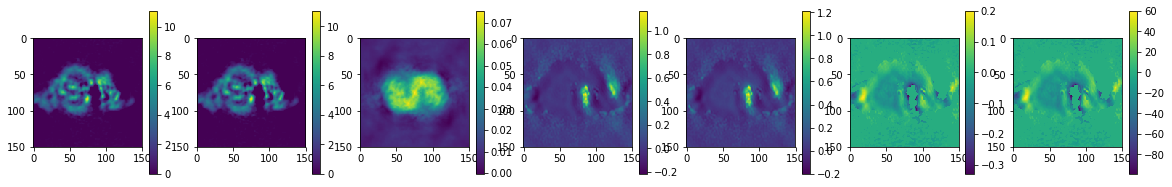

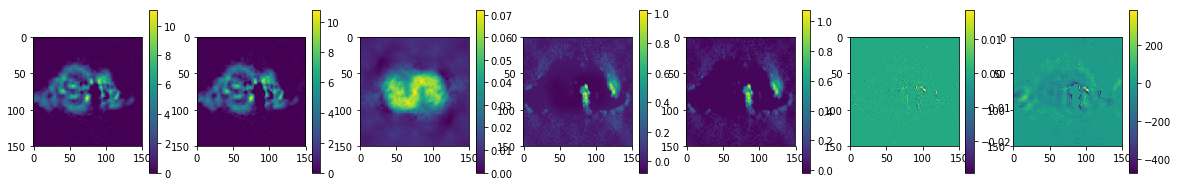

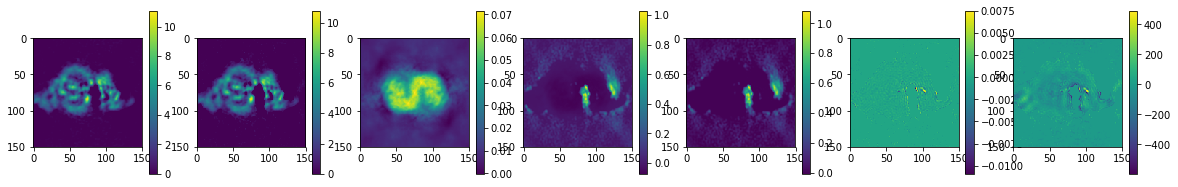

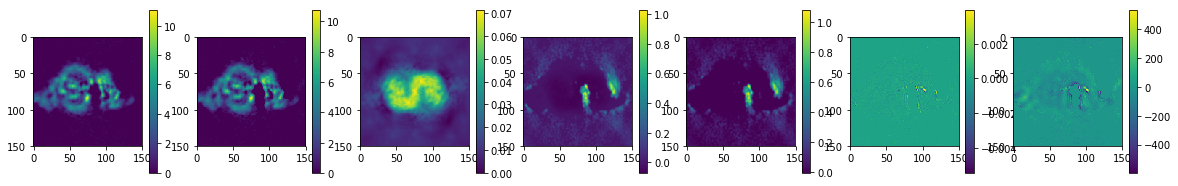

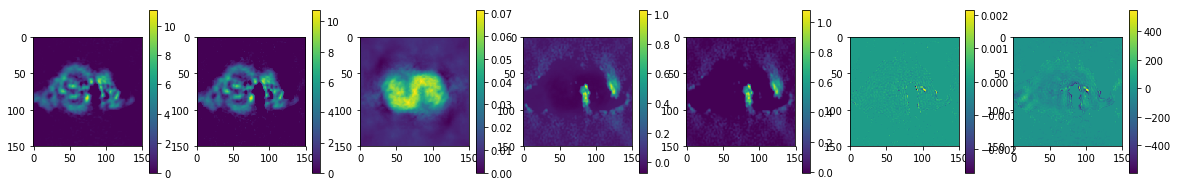

KeyboardInterrupt: 

In [7]:
ADVERSARIAL_REGULARIZATION = 1e-4
STEP_SIZE_BASE = 1e-0
STEPS = 150

# PRECONDITIONING -- no preconditioning

# precond = np.abs(np.divide(1, kernel + TIKHONOV_REGULARIZATION))
# precond /= precond.max()
# print(precond.max()/precond.min())
precond = 1

# Initialize with Tychonov reconstruction
reco = np.copy(tk_pos)

for k in range(2*STEPS):
    STEP_SIZE = STEP_SIZE_BASE #/ np.sqrt(1 + k / 20)
    
    ######
    # Computing the gradient
    
    reco_ds = downsample(reco)
    gradient_tmp = regularizer.evaluate(reco_ds)
    gradient = upsample(gradient_tmp)
    
    ######
    # Gradient update
    
    g1 = ADVERSARIAL_REGULARIZATION * gradient
    g2 = (np.multiply(reco, tikhonov_kernel) - complex_data)
    
    g = g1 + g2
    
    reco_o = np.copy(reco)
    reco = reco - STEP_SIZE * precond * g
    reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))
        
    if k%30 == 0:
#        print(np.max(irfft(reco, scaling=NUM_VOX**2)))
        plt.figure(k, figsize=(20, 3))
        plt.subplot(171)
        vis(tk_pos)
        plt.colorbar()
        plt.subplot(172)
        vis(reco)
        plt.colorbar()
        plt.subplot(173)
        vis(precond*g1)
        plt.colorbar()
        plt.subplot(174)
        vis(precond*g2)
        plt.colorbar()
        plt.subplot(175)
        vis(precond*g)
        plt.colorbar()
        plt.subplot(176)
        vis(reco-reco_o)
        plt.colorbar()
        plt.subplot(177)
        vis(IMAGING_SCALE*(reco - tk_pos))
        plt.colorbar()
        plt.show()

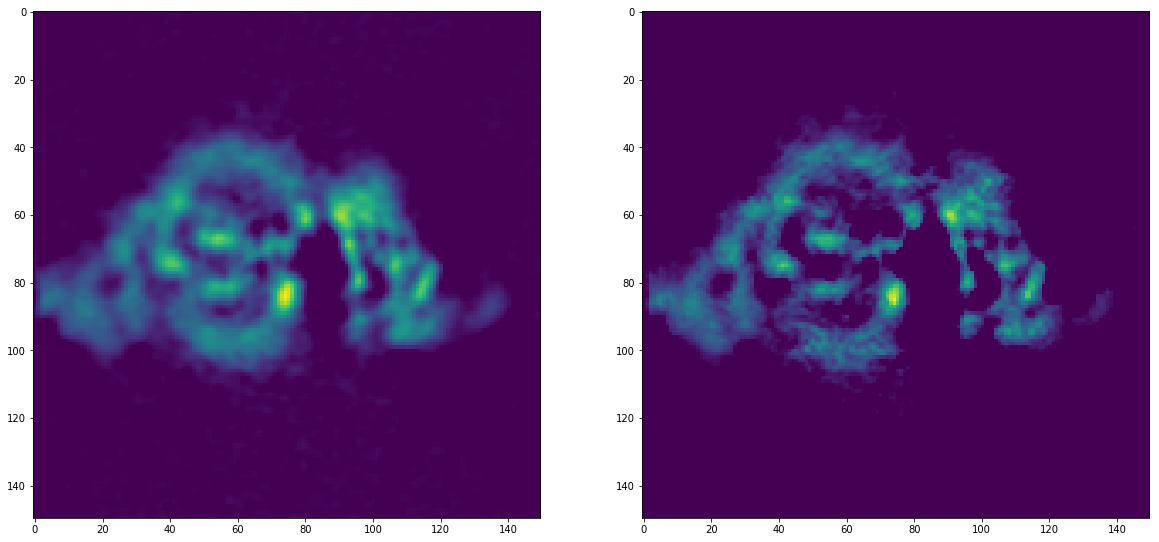

In [82]:
plt.figure(figsize=(20,20))
plt.subplot(121)
vis((tk_pos))
plt.subplot(122)
vis((reco))

In [1]:
path = '/local/scratch/public/sl767/MRC_Data/RealLifeAR/A2A_VPP/seb_pars/run_it012_half2_class001.mrc'
with mrcfile.open(path) as mrc:
    tmp = mrc.data.copy()
vis(tmp, fourier=False)

NameError: name 'mrcfile' is not defined